<a href="https://colab.research.google.com/github/fkvivid/DIVER/blob/main/mep_day19_CNN2_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import
import numpy as np
import matplotlib.pyplot as plt

# Evaluation index
from sklearn.metrics import accuracy_score

In [1]:
# Download the MNIST dataset
from keras.datasets import mnist
(X, y), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# Check the data
print(X.shape) # (60000, 28, 28)
print(X.shape) # (10000, 28, 28)
print(X[0].dtype) # uint8

(60000, 28, 28)
(60000, 28, 28)
uint8


In [4]:
# Type conversion, normalization
X = X.astype(np.float)
X_test = X_test.astype(np.float)
X /= 255
X_test /= 255
print(X.max()) # 1.0
print(X.min()) # 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


1.0
0.0


In [5]:
# One-hot encoding of correct label value
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y.shape) # (60000,)
print(y_one_hot.shape) # (60000, 10)
print(y_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [6]:
# Split into training data and validation data
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y_one_hot, test_size=0.2)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(48000, 28, 28)
(12000, 28, 28)
(48000, 10)
(12000, 10)


### Preparing for NN classes and other activities so far

#### All binding layers

In [7]:
class FC:
    """
    Fully connected layers from number of nodes n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in subsequent layers
    initializer : Instances of initialization methods
    optimizer : Instances of optimization methods
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):
        
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        # Initialize.
        # Use the initializer method to initialize self.W and self.B
        self.W = self.initializer.W(self.n_nodes1,self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        
    def forward(self, X):
        """
        Forward
        Parameters
        ----------
        X : ndarray of the following form, shape (batch_size, n_nodes1)
            Input
        Returns
        ----------
        A : ndarray of the following form, shape (batch_size, n_nodes2)
            Output
        """
        self.X = X
        self.A = np.dot(self.X,self.W) + self.B
        
        return self.activation.forward(self.A)
    
    def backward(self, dZ):
        """
        Backward
        Parameters
        ----------
        dA : ndarray of the following form, shape (batch_size, n_nodes2)
            The gradient flowed in from behind.
        Returns
        ----------
        dZ : ndarray of the following form, shape (batch_size, n_nodes1)
            forward slope
        """
        dA = self.activation.backward(dZ)
        self.dB = np.mean(dA,axis=0)
        self.dW = np.dot(self.X.T,dA)/len(self.X)
        dZ = np.dot(dA,self.W.T)
        
        # Update
        self = self.optimizer.update(self)
        
        return dZ

#### Initialization

In [8]:
class SimpleInitializerConv2d:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, F, C, FH, FW):
        """
        Initializing weights
        Parameters
        ----------
        
        Returns
        ----------
        W : weight
        """
        return self.sigma * np.random.randn(F,C,FH,FW)
    
    def B(self, F):
        """
        Bias initialization
        Parameters
        ----------

        Returns
        ----------
        B : bias
        """
        return np.zeros(F)

In [9]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        Initializing weights
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        W : weight
        """
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        B : bias
        """
        return np.zeros(n_nodes2)

In [10]:
class HeInitializer():
    """
    Initialization of weights by He
    """
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        Initializing weights
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        W : weight
        """
        return np.random.randn(n_nodes1, n_nodes2)*np.sqrt(2/n_nodes1)
    
    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        B : bias
        """
        return np.zeros(n_nodes2)

#### optimization

In [11]:
class SGD:
    """
    stochastic gradient descent method
    Parameters
    ----------
    lr : learning rate
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, layer):
        """
        Updating the weights and biases of a layer
        Parameters
        ----------
        layer : An instance of the layer before the update
        """
        layer.W -= self.lr*layer.dW
        layer.B -= self.lr*layer.dB
        
        return layer

In [12]:
class AdaGrad:
    """
    stochastic gradient descent method
    Parameters
    ----------
    lr : learning rate
    """
    def __init__(self, lr):
        self.lr = lr
        self.hW = 0
        self.hB = 0
        
    def update(self, layer):
        """
        Updating the weights and biases of a layer
        Parameters
        ----------
        layer : An instance of the layer before the update
        """
        self.hW += layer.dW*layer.dW
        self.hB = layer.dB*layer.dB
    
        layer.W -= self.lr*layer.dW/(np.sqrt(self.hW) +1e-7)
        layer.B -= self.lr*layer.dB/(np.sqrt(self.hB) +1e-7)
        
        return layer

#### Activation function

In [13]:
class ReLU():
    """
    Activation function : ReLU function
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        self.A = A
        return np.maximum(self.A,0)
    
    def backward(self,dZ):
        
        return np.where(self.A>0,dZ,0)

In [14]:
class Softmax():
    """
    Activation Function : Softmax Function
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        
        return np.exp(A-np.max(A))/np.sum(np.exp(A-np.max(A)),axis=1,keepdims=True)
    
    def backward(self,dZ):
        return dZ

#### Mini-batch

In [15]:
# Mini-batch processing class
class GetMiniBatch:
    """
    Iterator to get the mini-batch

    Parameters
    ----------
    X : ndarray of the following form, shape (n_samples, n_features)
      Training data
    y : ndarray of the following form, shape (n_samples, 1)
      correct value
    batch_size : int
      Batch size
    seed : int
      Seeding random numbers in NumPy
    """
    def __init__(self, X, y, batch_size = 20, seed=None):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1] 
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

### 【Problem 1】Creating a 2-D convolutional layer
Expand the class Conv1d of 1D convolutional layers to create the class Conv2d of 2D convolutional layers.

The formula for forward propagation is as follows

#### convolutional layer class

In [16]:
# 2d convolutional layer class
class SimpleConv2d():
    """
    2-D convolutional layer
    Parameters
    ----------
    initializer : Instances of initialization methods
    optimizer : Instances of optimization methods
    """
    def __init__(self, F, C, FH, FW, P, S,
                 initializer=None,optimizer=None,activation=None):
        self.P = P
        self.S = S
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        
        # Initialize.
        # Use the initializer method to initialize self.W and self.B
        self.W = self.initializer.W(F,C,FH,FW)
        self.B = self.initializer.B(F)
        
    def output_shape2d(self,H,W,PH,PW,FH,FW,SH,SW):
        OH = (H +2*PH -FH)/SH +1
        OW = (W +2*PW -FW)/SW +1
        return int(OH),int(OW)
    
    def forward(self, X):
        """
        forward 
        Parameters
        ----------
        X : ndarray of the following form, shape (batch_size, n_nodes1)
            Input
        Returns
        ----------
        A : ndarray of the following form, shape (batch_size, n_nodes2)
            Output
        """
        self.X = X
        N,C,H,W = self.X.shape
        F,C,FH,FW = self.W.shape
        
        OH,OW = self.output_shape2d(H,W,self.P,self.P,FH,FW,self.S,self.S)
        
        self.params = N,C,H,W,F,FH,FW,OH,OW

        A = np.zeros([N,F,OH,OW])

        self.X_pad = np.pad(self.X,((0,0),(0,0),(self.P,self.P),(self.P,self.P)))

        # Batch
        for n in range(N):
            # Output channels
            for ch in range(F):
                # Vertical slide
                for row in range(0,H,self.S):
                    # Horizontal Slide
                    for col in range(0,W,self.S):
                        A[n,ch,row,col] = \
                        np.sum(self.X_pad[n,:,row:row+FH,col:col+FW]
                               *self.W[ch,:,:,:]) \
                        +self.B[ch]
        
        return  self.activation.forward(A)
    
    def backward(self, dZ):
        """
        backward
        Parameters
        ----------
        dA : ndarray of the following form, shape (batch_size, n_nodes2)
            The gradient flowed in from behind.
        Returns
        ----------
        dZ : ndarray of the following form, shape (batch_size, n_nodes1)
            forward slope
        """
        
        dA = self.activation.backward(dZ)
        N,C,H,W,F,FH,FW,OH,OW = self.params
        
        dZ = np.zeros(self.X_pad.shape)
        self.dW = np.zeros(self.W.shape)
        self.dB = np.zeros(self.B.shape)
        
        # dZ
        # Batch
        for n in range(N):
            # Output channels
            for ch in range(F):
                # Vertical slide
                for row in range(0,H,self.S):
                    # Horizontal Slide
                    for col in range(0,W,self.S):
                        dZ[n,:,row:row+FH,col:col+FW] += dA[n,ch,row,col]*self.W[ch,:,:,:]
                
        dl_rows = range(self.P),range(H+self.P,H+2*self.P,1)
        dl_cols = range(self.P),range(W+self.P,W+2*self.P,1)

        dZ = np.delete(dZ,dl_rows,axis=2)
        dZ = np.delete(dZ,dl_cols,axis=3)
                
        # dW
        # Batch
        for n in range(N):
            # Output channels
            for ch in range(F):
                # Vertical slide
                for row in range(OH):
                    # Horizontal Slide
                    for col in range(OW):
                        self.dW[ch,:,:,:] += dA[n,ch,row,col]*self.X_pad[n,:,row:row+FH,col:col+FW]
        
        # dB
        # Output channels
        for ch in range(F):
            self.dB[ch] = np.sum(dA[:,ch,:,:])
        
        # Update
        self = self.optimizer.update(self)
        
        return dZ

### 【Problem 2】Output size after 2-D convolution
Convolution changes the size of the feature map.  
How it changes can be obtained from the following formula.  
Create a function to do this calculation.

In [17]:
def output_shape2d(IH=5,IW=5,PH=0,PW=0,FH=3,FW=3,SH=1,SW=1):
    OH = (IH +2*PH -FH)/SH +1
    OW = (IW +2*PW -FW)/SW +1
    return int(OH),int(OW)

In [18]:
print(output_shape2d(IH=6,IW=6,PH=0,PW=0,FH=3,FW=3,SH=1,SW=1))

(4, 4)


#### Experiment with 2D convolution

In [19]:
N,C,H,W = (5,1,28,28)
F,C,FH,FW = (4,1,3,3)

S = 1 #Fixed for now
P = 1

OH,OW = output_shape2d(H,W,P,P,FH,FW,S,S)

A = np.zeros([N,F,OH,OW])

X_sample = X[0:N].reshape(N,C,H,W)
X_pad = np.pad(X_sample,((0,0),(0,0),(P,P),(P,P)))
w = np.ones([F,C,FH,FW])
B = np.ones(F)

# Forward

# Batch
for n in range(N):
    # Output channels
    for ch in range(F):
        # Vertical slide
        for row in range(0,H,S):
            # Horizontal Slide
            for col in range(0,W,S):
                A[n,ch,row,col] = \
                np.sum(X_pad[n,:,row:row+FH,col:col+FW]*w[ch,:,:,:]) +B[ch]
                
print('A.shape:',A.shape)

A.shape: (5, 4, 28, 28)


In [20]:
# Backward
dA = np.ones(A.shape)

dZ = np.zeros(X_pad.shape)
dW = np.zeros(w.shape)
dB = np.zeros(B.shape)

# dZ
# Batch
for n in range(N):
    # Output channels
    for ch in range(F):
        # Vertical slide
        for row in range(0,H,S):
            # Horizontal Slide
            for col in range(0,W,S):
                dZ[n,:,row:row+FH,col:col+FW] += dA[n,ch,row,col]*w[ch,:,:,:]
                
dl_rows = range(P),range(H+P,H+2*P,1)
dl_cols = range(P),range(W+P,W+2*P,1)

dZ = np.delete(dZ,dl_rows,axis=2)
dZ = np.delete(dZ,dl_cols,axis=3)
                
# dW
# Batch
for n in range(N):
    # Output channels
    for ch in range(F):
        # Vertical slide
        for row in range(OH):
            # Horizontal Slide
            for col in range(OW):
                dW[ch,:,:,:] += dA[n,ch,row,col]*X_pad[n,:,row:row+FH,col:col+FW]
                
# dB
# Output channels
for ch in range(F):
    dB[ch] = np.sum(dA[:,ch,:,:])
                
print('dZ.shape:',dZ.shape)
print('dW.shape:',dW.shape)
print('dB.shape:',dB.shape)

dZ.shape: (5, 1, 28, 28)
dW.shape: (4, 1, 3, 3)
dB.shape: (4,)


### 【Problem 3】Creating a maximum pooling layer
Create a class MaxPool2D for the maximum pooling layer.  
Some parts of the pooling layer are easier to understand if they are not expressed in mathematical form, but if they are expressed in mathematical form, the forward propagation looks like this

In [21]:
class MaxPool2D():
    
    def __init__(self,P):
        self.P = P
        self.PA = None
        self.Pindex = None
        
    def forward(self,A):
        N,F,OH,OW = A.shape
        PS = self.P
        PH,PW = int(OH/PS),int(OW/PS)
        
        self.params = N,F,OH,OW,PS,PH,PW
        
        # Pooling filter
        self.PA = np.zeros([N,F,PH,PW])
        self.Pindex = np.zeros([N,F,PH,PW])
        
        for n in range(N):
            # Output channels
            for ch in range(F):
                # Vertical slide
                for row in range(PH):
                    # Horizontal Slide
                    for col in range(PW):
                        self.PA[n,ch,row,col] = \
                        np.max(A[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS])
                        
                        self.Pindex[n,ch,row,col] = \
                        np.argmax(A[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS])
                        
        return self.PA
    
    def backward(self,dA):
        
        N,F,OH,OW,PS,PH,PW = self.params
        dP = np.zeros([N,F,OH,OW])
        
        for n in range(N):
            # Output channels
            for ch in range(F):
                # Vertical slide
                for row in range(PH):
                    # Horizontal Slide
                    for col in range(PW):
                        idx = self.Pindex[n,ch,row,col]
                        tmp = np.zeros((PS*PS))
                        for i in range(PS*PS):
                            if i == idx:
                                tmp[i] = dA[n,ch,row,col]
                            else:
                                tmp[i] = 0
                        dP[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS] = tmp.reshape(PS,PS)
        
        return dP

In [22]:
X = np.random.randint(0,9,36).reshape(1,1,6,6)
print(X)

[[[[8 3 2 4 6 2]
   [5 2 2 5 3 3]
   [0 7 4 2 1 2]
   [7 7 0 3 1 4]
   [7 6 3 1 8 5]
   [5 0 3 6 1 0]]]]


In [23]:
Pooling = MaxPool2D(P=2)
A = Pooling.forward(X)

print(A.shape)
print(A)

(1, 1, 3, 3)
[[[[8. 5. 6.]
   [7. 4. 4.]
   [7. 6. 8.]]]]


In [24]:
Pooling.Pindex

array([[[[0., 3., 0.],
         [1., 0., 3.],
         [0., 3., 0.]]]])

In [25]:
dA = np.random.randint(0,9,9).reshape(A.shape)
print(dA)

[[[[7 5 5]
   [7 5 2]
   [4 4 2]]]]


In [26]:
dZ = Pooling.backward(dA)

print(dZ)

[[[[7. 0. 0. 0. 5. 0.]
   [0. 0. 0. 5. 0. 0.]
   [0. 7. 5. 0. 0. 0.]
   [0. 0. 0. 0. 0. 2.]
   [4. 0. 0. 0. 2. 0.]
   [0. 0. 0. 4. 0. 0.]]]]


### 【Problem 4】(Advanced Problem) Creating Average Pooling
Create a class AveragePool2D for the average pooling layer.

This is a pooling layer that outputs the average value instead of the maximum value in a range.

In image recognition, the maximum pooling layer is commonly used, while the average pooling is not often used.

In [27]:
class AveragePool2D():
    
    def __init__(self,P):
        self.P = P
        self.PA = None
        self.Pindex = None
        
    def forward(self,A):
        N,F,OH,OW = A.shape
        PS = self.P
        PH,PW = int(OH/PS),int(OW/PS)
        
        self.params = N,F,OH,OW,PS,PH,PW
        
        # Pooling filter
        self.PA = np.zeros([N,F,PH,PW])
        
        for n in range(N):
            # Output channels
            for ch in range(F):
                # Vertical slide
                for row in range(PH):
                    # Horizontal Slide
                    for col in range(PW):
                        self.PA[n,ch,row,col] = \
                        np.mean(A[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS])
                        
        return self.PA
    
    def backward(self,dA):
        
        N,F,OH,OW,PS,PH,PW = self.params
        dP = np.zeros([N,F,OH,OW])
        
        for n in range(N):
            # Output channels
            for ch in range(F):
                # Vertical slide
                for row in range(PH):
                    # Horizontal Slide
                    for col in range(PW):
                        tmp = np.zeros((PS*PS))
                        for i in range(PS*PS):
                            tmp[i] = dA[n,ch,row,col]/(PS*PS)

                        dP[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS] = tmp.reshape(PS,PS)
        
        return dP

In [28]:
X = np.random.randint(0,9,36).reshape(1,1,6,6)
print(X)

[[[[1 4 7 3 0 0]
   [5 1 1 6 6 0]
   [8 6 5 0 8 4]
   [6 1 4 2 7 0]
   [1 8 2 8 8 0]
   [2 7 0 2 3 6]]]]


In [29]:
Pooling = AveragePool2D(P=2)
A = Pooling.forward(X)

print(A.shape)
print(A)

(1, 1, 3, 3)
[[[[2.75 4.25 1.5 ]
   [5.25 2.75 4.75]
   [4.5  3.   4.25]]]]


In [30]:
dA = np.random.randint(0,9,9).reshape(A.shape)
print(dA)

[[[[6 1 0]
   [8 0 1]
   [2 8 6]]]]


In [31]:
dZ = Pooling.backward(dA)

print(dZ)

[[[[1.5  1.5  0.25 0.25 0.   0.  ]
   [1.5  1.5  0.25 0.25 0.   0.  ]
   [2.   2.   0.   0.   0.25 0.25]
   [2.   2.   0.   0.   0.25 0.25]
   [0.5  0.5  2.   2.   1.5  1.5 ]
   [0.5  0.5  2.   2.   1.5  1.5 ]]]]


### 【Problem 5】Flatten
Create a Flatten class for smoothing.

In the forward direction, reshape the three dimensions of channel, height, and width to one dimension. The values are recorded and reshaped again in the backward direction.

By sandwiching this smoothing class in between, we can create an array suitable for all coupled layers before output.

In [32]:
class Flatten:
    def __ini__(self,):
        pass
    def forward(self,X):
        self.shape = X.shape
        return X.reshape(len(X),-1)

    def backward(self,X):
        return X.reshape(self.shape)        

In [33]:
TEST = np.zeros([20,2,5,5])
flt = Flatten()
flat_forward = flt.forward(TEST)
print('Forward_shape:',flat_forward.shape)
print('Backward_shape:',flt.backward(flat_forward).shape)

Forward_shape: (20, 50)
Backward_shape: (20, 2, 5, 5)


### 【Problem 6】Training and Estimation
Use the Conv2d you created to train and estimate MNIST and calculate the Accuracy.

Please aim to make it work first, even if the accuracy is low.

In [34]:
# Scratch CNN
class Scratch2dCNNClassifier():
    """
    N-Layer Convolutional Neural Network Classifier
    
    Parameters
    ----------
    self.n_epoch : epoch number
    self.n_batch : Number of batches
    self.verbose : Visualizing the learning process
    Attributes
    ----------
    """
    def __init__(self, NN, CNN, n_epoch=5, n_batch=1, verbose = False):
        # Parameters
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.verbose = verbose
        self.log_loss = np.zeros(self.n_epoch)
        self.log_acc = np.zeros(self.n_epoch)
        self.NN = NN
        self.CNN = CNN
        
    def loss_function(self,y,yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))
    
    def accuracy(self,Z,Y):
        return accuracy_score(Y,Z)
                
    def fit(self, X, y, X_val=False, y_val=False):
        """
        Train a neural network classifier.

        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Features of training data
        y : ndarray of the following form, shape (n_samples, )
            Correct answer value of training data
        X_val : ndarray of the following form, shape (n_samples, n_features)
            Features of validation data
        y_val : ndarray of the following form, shape (n_samples, )
            Correct value of validation data
        """
        for epoch in range(self.n_epoch):
            # Mini-batch processing
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)
            
            self.loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                                
                # Forward propagation
                forward_data = mini_X_train[:,np.newaxis,:,:]
                
                # Conv
                for layer in range(len(self.CNN)):
                    forward_data = self.CNN[layer].forward(forward_data)
                
                # Flatten
                flt = Flatten()
                forward_data = flt.forward(forward_data)
                
                # NN
                for layer in range(len(self.NN)):
                    forward_data = self.NN[layer].forward(forward_data)
                    
                # Predicted value
                Z = forward_data
                
                # Back propagation
                backward_data = (Z - mini_y_train)/self.n_batch
                for layer in range(len(self.NN)-1,-1,-1):
                    backward_data = self.NN[layer].backward(backward_data)
                   
                    
                backward_data = flt.backward(backward_data)
                
                for layer in range(len(self.CNN)-1,-1,-1):
                    backward_data = self.CNN[layer].backward(backward_data)
                
                # Loss function
                self.loss += self.loss_function(Z,mini_y_train)
                
            self.log_loss[epoch] = self.loss/len(get_mini_batch)
            self.log_acc[epoch] = self.accuracy(self.predict(X),np.argmax(y,axis=1))
            
    def predict(self, X):
        """
        Estimate using a neural network classifier.。

        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Sample

        Returns
        -------
            ndarray of the following, shape (n_samples, 1)
            Estimation results
        """
        pred_data = X[:,np.newaxis,:,:]
        
        # Conv
        for layer in range(len(self.CNN)):
            pred_data = self.CNN[layer].forward(pred_data)
                
        pred_data = flt.forward(pred_data)
        
        # NN
        for layer in range(len(self.NN)):
            pred_data = self.NN[layer].forward(pred_data)
            
        return np.argmax(pred_data,axis=1)

In [35]:
# All bonding layers
NN = {0:FC(7840, 400, HeInitializer(), AdaGrad(0.01), ReLU()),
      1:FC(400, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
      2:FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
     }

In [36]:
# Convolutional layers
CNN = {0:SimpleConv2d(F=10, C=1, FH=3, FW=3, P=1, S=1,
                      initializer=SimpleInitializerConv2d(),
                      optimizer=SGD(),
                      activation=ReLU())}

In [37]:
# Learning
cnn1 = Scratch2dCNNClassifier(NN=NN,CNN=CNN,n_epoch=10,n_batch=200,verbose=False)

cnn1.fit(X_train[0:1000],y_train[0:1000])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

In [38]:
# Estimate
y_pred = cnn1.predict(X_valid[0:100])

# Positive solution rate
accuracy = accuracy_score(np.argmax(y_valid[0:100],axis=1), y_pred)
print('accuracy:{:.3f}'.format(accuracy))

accuracy:0.870


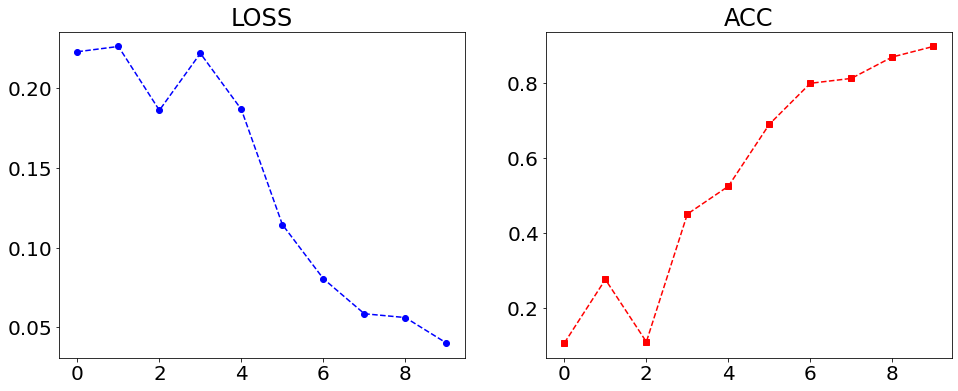

In [39]:
# Visualize the loss function for each epoch
plt.rcParams["font.size"] = 20
fig=plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(cnn1.log_loss,'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(cnn1.log_acc,'rs--');

* As a result of running it on the mini-data, the LOSS is coming down, and the percentage of correct answers, as well.

### 【Problem 9】Calculating output size and number of parameters
When building a CNN model, it is necessary to calculate the number of features in advance at the stage of inputting them into the all-connected layer.

Also, when dealing with huge models, the calculation of the number of parameters becomes essential due to memory and computation speed. The framework can display the number of parameters for each layer, but without understanding the meaning, it is impossible to make appropriate adjustments.

Calculate the output size and the number of parameters for the following three convolutional layers. For the number of parameters, also consider the bias term.

1.

* Input size : 144x144, 3 channels
* Filter size : 3×3, 6 channels
* Stride : 1
* Padding : None

→ Output size : 6×142×142, Number of parameters : 168 (Weight 162, Bias 6)

2.

* Input size : 60×60, 24 channels
* Filter size: 3×3, 48 channels
* Stride : 1
* Padding : None

→ Output size : 48×58×58, Number of parameters : 10416(Weight 10368, Bias 48)

3.

* Input size: 20x20, 10 channels
* Filter size: 3×3, 20 channels
* Stride : 2
* Padding : None

→ Output size: 20x9x9, Number of parameters: 1820 (weights 1800, bias 20)

The last example is a case where the convolution cannot be done just right. The framework sometimes does not look at the extra pixels, so please consider that case in your calculations. This is an example of why this kind of setting is not desirable, because it will result in missing edges.